# Baseline Model

In this notebook, we load the relevant feature vectors generated using a pre-trained ResNet50 model and then create a baseline model using the train, dev and val data that we generated previously.

Within the notebook, there is also code to oversample the data and we test our model, both on the no-oversampled and oversampled dataset.

Further, we use custom loss and accuracy functions which are defined below in the notebook.

### Load Modules <a id="load" />


In [0]:
#%tensorflow_version 2.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 33.7MB/s 
     |████████████████████████████████| 3.9MB 33.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=46de373eb11d686ffafb830598c446609178ba2ae368c7dbb95ec3cbd1a642d6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as tfb

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras import initializers


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ERROR_TEST = 0
OVERSAMPLING = False

if (ERROR_TEST):
    NUM_LABELS = 1
    OVERSAMPLING = False

    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/data/baseline_test/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/model/baseline_test/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/plots/baseline_test/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'

else:
    NUM_LABELS = 10

    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/data/baseline/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/model/baseline/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/Posters/plots/baseline/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'


### Load Dataset <a id="loadData" />


In [0]:
y_train = np.load(data_load_prefix + 'clean_train_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_dev = np.load(data_load_prefix + 'clean_dev_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_val = np.load(data_load_prefix + 'clean_val_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)

X_train = np.load(data_load_prefix + 'clean_train_poster_vectors.data.npy', allow_pickle=True)
X_dev = np.load(data_load_prefix + 'clean_dev_poster_vectors.data.npy', allow_pickle=True)
X_val = np.load(data_load_prefix + 'clean_val_poster_vectors.data.npy', allow_pickle=True)

In [0]:
print(X_train.shape)
print(X_dev.shape)
print(X_val.shape)

(46970, 2048)
(15438, 2048)
(15600, 2048)


In [0]:
print(y_train.shape)
print(y_dev.shape)
print(y_val.shape)

(46970, 10)
(15438, 10)
(15600, 10)


In [0]:
np.max(X_train[0])

10.994573

In [0]:
use_cols = ['movieid', 'movieplot']
df = pd.read_csv('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/clean_poster_data_' + str(NUM_LABELS) + '.csv',
                 usecols=use_cols)
df.head()

,movieid,movieplot
0,tt0007610,A judge who had taken part in the gold rush of...
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo..."
2,tt0007257,"Reggie, a wealthy young man about town, is eag..."
3,tt0008011,"Living in the country with her widowed mother,..."
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...


In [0]:
df.shape

(78008, 2)

In [0]:
len(df.movieid.unique())

78008

In [0]:
# Oversampling Train Dataset

In [0]:
def oversample_keeping_original(X, y, bottom_n = 6, count_per_category = 5000):
    genre_counts = np.sum(y,axis = 0)
    genre_sorted_index = np.argsort(genre_counts)[:bottom_n]
    np.random.seed(0)
    
    new_y = np.array([])
    new_X = np.array([])
    list_samples = np.array([])
    for index,i in enumerate(genre_sorted_index):
        indices = np.where(y[:,i]>0)
        samples = np.random.choice(indices[0],count_per_category)
        # print(i,samples[-20:])
        if index==0:
            new_y = np.concatenate((y, y[samples,:]), axis = 0)
            new_X = np.concatenate((X, X[samples,:]), axis = 0)
            print("index 0 ", np.arange(X.shape[1]))
            list_samples = np.concatenate((np.arange(X.shape[0]) ,samples), axis = 0)
        else:
            new_y = np.concatenate((new_y, y[samples,:]), axis=0)
            new_X = np.concatenate((new_X, X[samples,:]), axis = 0)
            list_samples = np.concatenate((list_samples, samples), axis=0)

    indexArray = np.arange(0, new_y.shape[0], 1, dtype=np.int32)
    print("Len of index array is ", len(indexArray))

    np.random.seed(0)
    np.random.shuffle(indexArray)

    print(new_X.shape)
    print(new_y.shape)
    print(list_samples.shape)

    return (new_X[indexArray], new_y[indexArray], list_samples[indexArray])

In [0]:
if (OVERSAMPLING):
    new_X_train, new_y_train, list_samples = oversample_keeping_original(X_train, y_train, bottom_n = 6, count_per_category = 5000)
    # new_df_train = df_train.iloc[list_samples]
    
    print(np.sum(y_train,axis = 0)/y_train.shape[0])
    print(np.sum(new_y_train,axis = 0)/new_y_train.shape[0])
    
    print(new_X_train.shape)
    print(new_y_train.shape)
    print(len(list_samples))

index 0  [   0    1    2 ... 2045 2046 2047]
Len of index array is  76970
(76970, 2048)
(76970, 10)
(76970,)
[0.55465191 0.19650841 0.34430488 0.15190547 0.13385139 0.11807537
 0.19759421 0.08909943 0.07404726 0.06086864]
[0.48726777 0.27334026 0.29650513 0.24108094 0.19822009 0.19175003
 0.16266078 0.16438872 0.14905807 0.14058724]
(76970, 2048)
(76970, 10)
76970


### Custom Loss and Accuracy Functions

In [0]:
#@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

#@tf.function
def micro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y)), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    micro_f1 = f1 #tf.reduce_mean(f1)
    return micro_f1

#@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

POS_WEIGHT = 10
#@tf.function
def weighted_binary_crossentropy(y, y_hat):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), y_hat.dtype.base_dtype)
    y_hat = tf.clip_by_value(y_hat, _epsilon, 1 - _epsilon)
    y_hat = tf.math.log(y_hat / (1 - y_hat))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=y,
                                                    logits=y_hat,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

#@tf.function
def binary_crossentropy(y, y_hat):

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # compute loss
    loss = tf.keras.backend.binary_crossentropy(y, y_hat, from_logits=False)
    return tf.reduce_mean(loss, axis=-1)

#@tf.function
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

### Model Params

In [0]:
optimizer_select = 'ADAM'
BATCH_SIZE = 128*16
EPOCHS = 100
LR = 1e-04
# LOSS = 'macro_soft_f1'
# LOSS = 'macro_double_soft_f1'
LOSS = 'bce'
ACC = ['accuracy', macro_f1, micro_f1]

In [0]:
X_train.shape

(46970, 2048)

In [0]:
if OVERSAMPLING:
    NUM_TRAIN_SAMPLES = int(np.floor(new_X_train.shape[0] / BATCH_SIZE) * BATCH_SIZE)
else:
    NUM_TRAIN_SAMPLES = int(np.floor(X_train.shape[0] / BATCH_SIZE) * BATCH_SIZE)

NUM_DEV_SAMPLES = int(np.floor(X_dev.shape[0] / BATCH_SIZE) * BATCH_SIZE)
NUM_VAL_SAMPLES = int(np.floor(X_val.shape[0] / BATCH_SIZE) * BATCH_SIZE)

if (OVERSAMPLING):
    results_prefix = 'baseline_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS)
else:
    results_prefix = 'baseline_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoOS'

In [0]:
print("Number Train Samples ", NUM_TRAIN_SAMPLES)

Number Train Samples  45056


In [0]:
NUM_LABELS

10

### Training Model

In [0]:
def select_optimizer(optimizer_select):
    if optimizer_select == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, name='Adam')
    elif optimizer_select == 'ADAMAX':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')
    elif optimizer_select == 'ADAGRAD':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=LR, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad')
    elif optimizer_select == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9, nesterov=True, name='SGD', clipvalue=0.5)
    elif optimizer_select == 'ADADELTA':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
    else:
        raise Exception('Optimizer not available')
    
    return optimizer

In [0]:
def select_loss(LOSS):
    if LOSS == 'bce':
        loss = binary_crossentropy
    elif LOSS == 'macro_double_soft_f1':
        loss = macro_double_soft_f1
    elif LOSS == 'macro_soft_f1':
        loss = macro_soft_f1
    else:
        raise Exception('Loss function not implemented...')

    return loss

In [0]:
def set_strategy():
    #this is for bfloat16 precision
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_policy(policy)

    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

    return policy, strategy

In [0]:
policy, strategy = set_strategy()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=1e-4,
                                              patience=10)]
optimizer = select_optimizer(optimizer_select)
loss = select_loss(LOSS)

# [64] # [64,64,128,256,512]
filter_size = []

# [[3]] # [[3,3,3,3,3]] # [[3,3,3,3,3], [7,7,7,7,7], [13,13,13,13,13]]
kernel_size = []

# [5120] # [5120,5120] # [2048,1024,1024]
dense_layers = [5120]

L2_REGULARIZATION = 0.0001
DROP_OUT = 0.5
DENSE_LAYER_SIZE = 5120

with strategy.scope():

    if len(kernel_size) >0 :
        feature_vector = tf.keras.layers.Input(shape=(2048,1),
                                               dtype=np.float32,
                                               name="ResnetFeatureVector")
    else:
        feature_vector = tf.keras.layers.Input(shape=(2048,),
                                               dtype=np.float32, 
                                               name="ResnetFeatureVector")

    batch_norm_list = []
    for j in range(0,len(kernel_size)):
        for i in range(0,len(filter_size)):
            if i==0:
                conv = tf.keras.layers.Conv1D(filters=filter_size[i],
                                              kernel_size=kernel_size[j][i],
                                              input_shape=(2048,1),
                                              padding='same',
                                              activation='relu',
                                              strides=1, 
                                              name='Conv_' + str(j)+str(i) + '_KernelSize_'+str(kernel_size[j][i]),
                                              data_format='channels_last')(feature_vector)
            else:
                conv = tf.keras.layers.Conv1D(filters=filter_size[i],
                                              kernel_size=kernel_size[j][i],
                                              padding='same',
                                              activation='relu',
                                              strides=1, 
                                              name='Conv_'+str(j)+str(i)+ '_KernelSize_'+str(kernel_size[j][i]),
                                              data_format='channels_last')(batch_norm)
            
            max_pooling = tf.keras.layers.MaxPool1D(strides=4,
                                                    pool_size=4,
                                                    data_format='channels_last', 
                                                    name='MaxPooling_'+ str(j)+str(i))(conv)
            
            batch_norm = tf.keras.layers.BatchNormalization(name='BatchNorm_'+str(j)+str(i))(max_pooling)
        batch_norm_list.append(batch_norm)
    
    if len(batch_norm_list) > 0:
        if (len(kernel_size) > 1):
            concat = tf.keras.layers.concatenate(batch_norm_list, 
                                                 name='FilterConcat')
            flatten = tf.keras.layers.Flatten(name='Flatten')(concat)
        else:
            flatten = tf.keras.layers.Flatten(name='Flatten')(batch_norm_list[-1])

    # for i in range(0,len(dense_layers)):
    #     if i==0:
    #         if len(batch_norm_list) > 0:
    #             dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                           activation='relu', 
    #                                           kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                           name='hidden_'+str(i))(flatten)
    #         else:
    #             dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                           activation='relu', 
    #                                           kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                           name='hidden_'+str(i))(feature_vector)
    #     else:
    #         dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(i))(dropout)

    #     dropout = tf.keras.layers.Dropout(rate=DROP_OUT, 
    #                                       name='dropout_'+str(i))(dense)

    # if (len(dense_layers) > 0):
    #     dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                   activation='relu', 
    #                                   kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                   name='hidden_'+str(len(dense_layers)))(dropout)#(feature_vector)#(dropout)#(concat_layer)
    # else:
    #     if len(batch_norm_list) > 0:
    #         dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(len(dense_layers)))(flatten)#(concat_layer)
    #     else:
    #         dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(len(dense_layers)))(feature_vector)

    # dropout = tf.keras.layers.Dropout(rate=DROP_OUT, 
    #                                   name='dropout_'+str(len(dense_layers)))(dense)

    # pred = tf.keras.layers.Dense(NUM_LABELS, 
    #                              activation='sigmoid',
    #                              name='pred')(dropout)

    pred = tf.keras.layers.Dense(NUM_LABELS, 
                                 activation='sigmoid',
                                 name='pred')(feature_vector)

    model = tf.keras.models.Model(inputs=feature_vector, 
                                  outputs=pred)

    model.summary()

    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=ACC)

    if OVERSAMPLING:
        if (len(kernel_size) > 0):
            history = model.fit(
                new_X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES].reshape(NUM_TRAIN_SAMPLES,2048,1),  
                new_y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],
                validation_data=(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES].reshape(NUM_DEV_SAMPLES,2048,1),
                                y_dev.astype(np.float32)[:NUM_DEV_SAMPLES]),
                epochs=EPOCHS,
                callbacks = callbacks,
                batch_size=BATCH_SIZE
            )
        else:
            history = model.fit(
                new_X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],  
                new_y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],
                validation_data=(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES],
                                y_dev.astype(np.float32)[:NUM_DEV_SAMPLES]),
                epochs=EPOCHS,
                callbacks = callbacks,
                batch_size=BATCH_SIZE
            )
    else:
        if (len(kernel_size) > 0):
            history = model.fit(
                X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES].reshape(NUM_TRAIN_SAMPLES,2048,1),  
                y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],
                validation_data=(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES].reshape(NUM_DEV_SAMPLES,2048,1),
                                y_dev.astype(np.float32)[:NUM_DEV_SAMPLES]),
                epochs=EPOCHS,
                callbacks = callbacks,
                batch_size=BATCH_SIZE
            )
        else:
            history = model.fit(
                X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],  
                y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES],
                validation_data=(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES],
                                y_dev.astype(np.float32)[:NUM_DEV_SAMPLES]),
                epochs=EPOCHS,
                callbacks = callbacks,
                batch_size=BATCH_SIZE
            )


INFO:tensorflow:Initializing the TPU system: 10.63.191.234:8470


INFO:tensorflow:Initializing the TPU system: 10.63.191.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResnetFeatureVector (InputLa [(None, 2048)]            0         
_________________________________________________________________
pred (Dense)                 (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________
Train on 45056 samples, validate on 14336 samples
Epoch 1/100
45056/45056 [==============================] - 4s 84us/sample - loss: 0.6389 - accuracy: 0.1379 - macro_f1: 0.1935 - micro_f1: 0.2896 - val_loss: 0.5812 - val_accuracy: 0.1463 - val_macro_f1: 0.1712 - val_micro_f1: 0.2875
Epoch 2/100
45056/45056 [==============================] - 0s 10us/sample - loss: 0.5637 - accuracy: 0.1497 - macro_f1: 0.1623 - micro_f1: 0.2877 - val_loss: 0.5477 - val_accuracy: 0.1553 - val_macro_f1: 0.1529 - val_micro_f1: 0.292

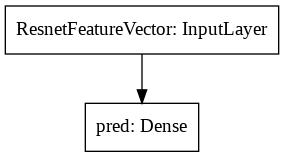

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=plot_save_prefix + 'model_architecture.png', show_shapes=False)

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_save_prefix + '/' + results_prefix + '_json.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights( model_save_prefix + '/' + results_prefix + '_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


### Evaluating Results

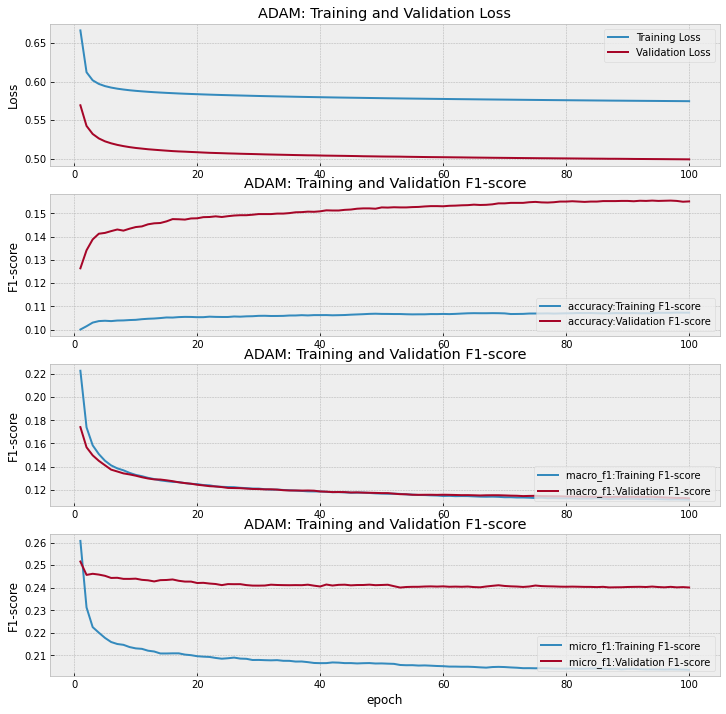

,loss,val_loss,macro_f1,micro_f1,val_macro_f1,val_micro_f1
95,0.574919,0.499407,0.107264,0.111661,0.155413,0.113314
96,0.574856,0.499334,0.107303,0.111529,0.155483,0.113098
97,0.574803,0.499276,0.107369,0.111598,0.155343,0.112869
98,0.574741,0.499213,0.107330,0.111497,0.154994,0.112898
99,0.574685,0.499152,0.107330,0.111347,0.155134,0.112551


In [0]:
import matplotlib.pyplot as plt
import matplotlib.style as style

def learning_curves(history,ACC):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = len(loss)
    style.use("bmh")
    num_plots = len(ACC) + 1
    plt.figure(figsize=(12, 12))

    plt.subplot(num_plots, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title(optimizer_select + ': Training and Validation Loss')

    ctr = 2
    accuracy = []
    val_accuracy = []
    for accs in ACC:
        if isinstance(accs, str):
            acc_name = accs
        else:
            acc_name = accs.__name__
        acc_data = history.history[acc_name]
        val_acc_data = history.history['val_'+acc_name]
        accuracy.append(acc_data)
        val_accuracy.append(val_acc_data)
        plt.subplot(num_plots, 1, ctr)
        plt.plot(range(1, epochs+1), acc_data, label= acc_name + ':' + 'Training F1-score')
        plt.plot(range(1, epochs+1), val_acc_data, label = acc_name + ':' + 'Validation F1-score')
        plt.legend(loc='lower right')
        plt.ylabel('F1-score')
        plt.title(optimizer_select + ': Training and Validation F1-score')
        #plt.xlabel('epoch')
        plt.savefig(plot_save_prefix + results_prefix + '.jpg')
        ctr+=1
    plt.xlabel('epoch')
    plt.show()
    return loss, val_loss, accuracy, val_accuracy

losses, val_losses,  accuracy, val_accuracy = learning_curves(history, ACC)

df_results = pd.DataFrame({'loss':losses,'val_loss': val_losses,
              'macro_f1':accuracy[0],'micro_f1':accuracy[1],
              'val_macro_f1':val_accuracy[0], 'val_micro_f1':val_accuracy[1]})
df_results.tail()

In [0]:
df_results.to_csv(plot_save_prefix + results_prefix + '.data', index=False)

In [0]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [0]:
if (ERROR_TEST):
    label_names = ['Drama']
else:
    label_names = ['Drama','Thriller','Comedy','Action','Crime',
                   'Horror','Romance','Adventure','Mystery','Sci-Fi']

In [0]:
n_thresh = 20
with strategy.scope():
    if OVERSAMPLING:
        grid_train = perf_grid(new_X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], # .reshape(NUM_TRAIN_SAMPLES,2048,1)
                y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], 
                label_names, 
                model, 
                n_thresh=n_thresh)
    else:
        grid_train = perf_grid(X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], # .reshape(NUM_TRAIN_SAMPLES,2048,1)
                y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], 
                label_names, 
                model, 
                n_thresh=n_thresh)
    grid_dev = perf_grid(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES], 
            y_dev.astype(np.float32)[:NUM_DEV_SAMPLES], 
            label_names, 
            model, 
            n_thresh=n_thresh)
    grid_val = perf_grid(X_val.astype(np.float32)[:NUM_VAL_SAMPLES], 
            y_val.astype(np.float32)[:NUM_VAL_SAMPLES], 
            label_names, 
            model, 
            n_thresh=n_thresh)

In [0]:
import seaborn as sns

def table_scores(grid_data, threshold):
    max_perf = grid_data.loc[grid_data.threshold==threshold,:].groupby(['id', 'label', 'threshold','freq','precision','recall'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
    max_perf.rename(columns={'f1':'f1score'}, inplace=True)
    max_perf.style.background_gradient(subset=['freq', 'f1score'], 
                                       cmap=sns.light_palette("lightgreen", as_cmap=True))
    return(max_perf)

table_scores(grid_train, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_train.f1score')
table_scores(grid_dev, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_dev.f1score')
table_scores(grid_val, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_val.f1score')
print(table_scores(grid_train, threshold=0.5))
print(table_scores(grid_dev, threshold=0.5))
print(table_scores(grid_val, threshold=0.5))


   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.554415  0.644390  0.596026
1   2     Comedy        0.5  0.34   0.346020  0.186060  0.241996
2   1   Thriller        0.5  0.20   0.185362  0.026417  0.046244
3   6    Romance        0.5  0.20   0.212683  0.024453  0.043863
4   5     Horror        0.5  0.12   0.110375  0.018839  0.032185
5   4      Crime        0.5  0.13   0.133234  0.014745  0.026551
6   7  Adventure        0.5  0.09   0.105634  0.011194  0.020243
7   3     Action        0.5  0.15   0.148472  0.009915  0.018589
8   8    Mystery        0.5  0.07   0.075472  0.002413  0.004676
9   9     Sci-Fi        0.5  0.06   0.028571  0.000728  0.001420
   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.558350  0.652125  0.601605
1   2     Comedy        0.5  0.35   0.349046  0.179775  0.237320
2   1   Thriller        0.5  0.19   0.197970  0.028037  0.049118
3   6    Romance        0

In [0]:
plot_save_prefix + results_prefix

'/content/drive/My Drive/w266-FinalProject/Posters/plots/baseline/baseline_ADAM_EPOCHS_100_LR_0.0001_LOSS_bce_NoOS'

In [0]:
# Only for single label
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(X, y_true, model, batch_size, num_labels,threshold=0.5):
    if (num_labels == 1):
        results = model.predict(X,batch_size=batch_size)
        cm = confusion_matrix(y_true.astype(np.int), (results > threshold).astype(np.int))
        print(cm)
    else:
        cm = None
    return(cm)

cm_train = get_confusion_matrix(X_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], 
                                y_train.astype(np.float32)[:NUM_TRAIN_SAMPLES], 
                                model, 
                                batch_size=BATCH_SIZE, 
                                num_labels=NUM_LABELS,
                                threshold=0.5)

cm_dev = get_confusion_matrix(X_dev.astype(np.float32)[:NUM_DEV_SAMPLES], 
                                y_dev.astype(np.float32)[:NUM_DEV_SAMPLES], 
                                model, 
                                batch_size=BATCH_SIZE, 
                                num_labels=NUM_LABELS,
                                threshold=0.5)

cm_val = get_confusion_matrix(X_val.astype(np.float32)[:NUM_VAL_SAMPLES], #.reshape(NUM_VAL_SAMPLES,2048,1) 
                                y_val.astype(np.float32)[:NUM_VAL_SAMPLES], 
                                model, 
                                batch_size=BATCH_SIZE, 
                                num_labels=NUM_LABELS,
                                threshold=0.5)


[[  773 19984]
 [  283 25552]]
[[ 127 6733]
 [ 147 8353]]
[[ 127 6599]
 [ 165 8469]]
